## Imports

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from os import listdir
from os.path import isfile, join

## Some initial config

In [211]:
INPUT_DIMS = [32,32]
BIN_DTYPE = 'int16'
PATH = "../Images/bin/"
SAMPLE = None
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.15/(1-TEST_SIZE)

## Generate label DataFrame

In [202]:
liver_images = np.array([f for f in listdir(PATH) if isfile(join(PATH, f))])
#print(f"Number of liver image files: {len(liver_images)}")
cancer_types = np.array([f.split('_')[0] for f in liver_images])
patient_numbers = np.array([int(f.split('_')[1]) for f in liver_images])
slice_numbers = np.array([int(f.split('_')[2].split('.')[0]) for f in liver_images])

ldata = {'filename' : liver_images, 
         'cancer_type' : cancer_types, 
         'patient_id' : patient_numbers, 
         'slice_number' : slice_numbers}

image_labels = pd.DataFrame(data=ldata).sort_values(['cancer_type','patient_id','slice_number'],
                                                   ignore_index=True)
if SAMPLE:
    image_labels = image_labels.sample(SAMPLE)
image_labels.head()

,filename,cancer_type,patient_id,slice_number
0,HCC_1_1.bin,HCC,1,1
1,HCC_1_2.bin,HCC,1,2
2,HCC_1_3.bin,HCC,1,3
3,HCC_1_4.bin,HCC,1,4
4,HCC_1_5.bin,HCC,1,5


### Display some sample images

In [203]:
def get_image(fpath,d_type=BIN_DTYPE,dims=INPUT_DIMS):
    '''
    Returns a numpy array given a .bin file path and
    image dimensionality. Assumes input bin files are square
    
    Parameters
        fpath: file path to .bin file
        d_type: data type of .bin file
        dims: image dimensionality
    Returns
        image: numpy array from bin file data
    '''
    im_data = np.fromfile(fpath,d_type)
    n = int(np.sqrt(len(im_data)))
    image = np.reshape(np.fromfile(fpath,d_type),[n,n])
    scaled_image = cv2.resize(image,dims)
    return scaled_image

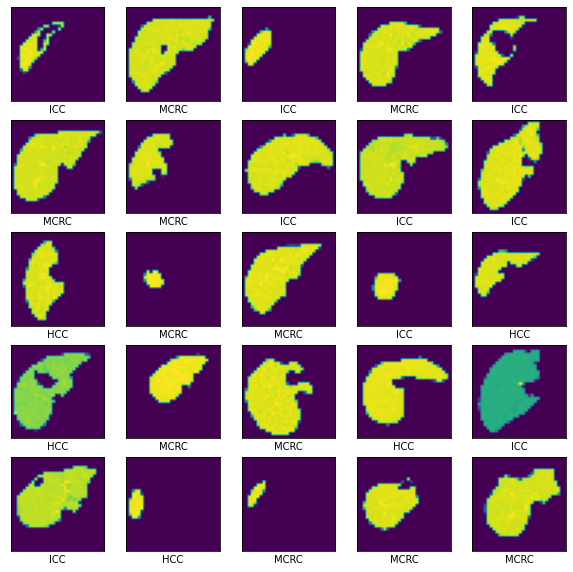

In [126]:
sample_labels = image_labels.sample(25)


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    img = get_image(PATH+sample_labels.filename.iloc[i])
    ctype = sample_labels.cancer_type.iloc[i]
    plt.imshow(img)
    plt.xlabel(ctype)
plt.show()

## Split Data into training and testing sets

In [139]:
#split df into cancer types
HCC_labels = image_labels.loc[image_labels.cancer_type == 'HCC']
ICC_labels = image_labels.loc[image_labels.cancer_type == 'ICC']
MCRC_labels = image_labels.loc[image_labels.cancer_type == 'MCRC']
print(f"{len(HCC_labels)} HCC images found")
print(f"{len(ICC_labels)} ICC images found")
print(f"{len(MCRC_labels)} MCRC images found")

5974 HCC images found
13140 ICC images found
9482 MCRC images found


In [140]:
from sklearn.model_selection import train_test_split

def split_patients(pat_ids,tsize=TEST_SIZE):
    train, test = train_test_split(pat_ids, test_size=tsize)
    return train, test

In [143]:
#for each cancer type, split into training, validation, and testing sets
hcc_all_train_ids, hcc_test_ids = split_patients(HCC_labels.patient_id.unique())
hcc_train_ids, hcc_valid_ids = split_patients(hcc_all_train_ids, VALIDATION_SIZE)

icc_all_train_ids, icc_test_ids = split_patients(ICC_labels.patient_id.unique())
icc_train_ids, icc_valid_ids = split_patients(icc_all_train_ids, VALIDATION_SIZE)

mcrc_all_train_ids, mcrc_test_ids = split_patients(MCRC_labels.patient_id.unique())
mcrc_train_ids, mcrc_valid_ids = split_patients(mcrc_all_train_ids, VALIDATION_SIZE)

#then generate label dataframes for each
HCC_train_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_train_ids)]
HCC_valid_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_valid_ids)]
HCC_test_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_test_ids)]

ICC_train_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_train_ids)]
ICC_valid_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_valid_ids)]
ICC_test_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_test_ids)]

MCRC_train_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_train_ids)]
MCRC_valid_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_valid_ids)]
MCRC_test_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_test_ids)]

In [148]:
train_rows=pd.concat([MCRC_train_labels,ICC_train_labels,HCC_train_labels],ignore_index=True).sample(frac=1)
valid_rows=pd.concat([MCRC_valid_labels,ICC_valid_labels,HCC_valid_labels],ignore_index=True).sample(frac=1)
test_rows=pd.concat([MCRC_test_labels,ICC_test_labels,HCC_test_labels],ignore_index=True).sample(frac=1)

total = len(train_rows) + len(valid_rows) + len(test_rows)
print(f"{total} total images split")
print(f"Train/validation/test ratio: {len(train_rows)/total:.2f}/{len(valid_rows)/total:.2f}/{len(test_rows)/total:.2f}")

28596 total images split
Train/validation/test ratio: 0.65/0.15/0.20


In [150]:
# dict to map cancer types to numerical classes
c_class = {'HCC':0,
          'ICC':1,
          'MCRC':2}

In [151]:
#preallocate training data array
n_train = len(train_rows)
train_images = np.zeros([n_train]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_train):
    print(f"{i+1}/{n_train}", end='\r')
    train_images[i,:,:]=get_image(PATH+train_rows.filename.iloc[i])

train_labels = np.array([[c_class[c]] for c in train_rows.cancer_type.tolist()])

In [152]:
#preallocate validation data array
n_valid = len(valid_rows)
valid_images = np.zeros([n_valid]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_valid):
    print(f"{i+1}/{n_valid}", end='\r')
    valid_images[i,:,:]=get_image(PATH+valid_rows.filename.iloc[i])

valid_labels = np.array([[c_class[c]] for c in valid_rows.cancer_type.tolist()])

In [153]:
#preallocate testing data array
n_test = len(test_rows)
test_images = np.zeros([n_test]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_test):
    print(f"{i+1}/{n_test}", end='\r')
    test_images[i,:,:]=get_image(PATH+test_rows.filename.iloc[i])

test_labels = np.array([[c_class[c]] for c in test_rows.cancer_type.tolist()])

## Create Convolutional Base

In [249]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(3, activation = 'softmax'))
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 2304)              0         
                                                                 
 dense_83 (Dense)            (None, 64)              

In [250]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, batch_size=32,
                    validation_data=(valid_images, valid_labels),verbose=True)

Epoch 1/10
583/583 [==============================] - 13s 22ms/step - loss: 3.1163 - accuracy: 0.4930 - val_loss: 1.0545 - val_accuracy: 0.4477
Epoch 2/10
583/583 [==============================] - 13s 22ms/step - loss: 0.9661 - accuracy: 0.5315 - val_loss: 1.0477 - val_accuracy: 0.4789
Epoch 3/10
583/583 [==============================] - 13s 23ms/step - loss: 0.8865 - accuracy: 0.5819 - val_loss: 1.0304 - val_accuracy: 0.5105
Epoch 4/10
583/583 [==============================] - 13s 23ms/step - loss: 0.8253 - accuracy: 0.6207 - val_loss: 1.1221 - val_accuracy: 0.4805
Epoch 5/10
583/583 [==============================] - 14s 24ms/step - loss: 0.7712 - accuracy: 0.6529 - val_loss: 1.1154 - val_accuracy: 0.4798
Epoch 6/10
583/583 [==============================] - 14s 25ms/step - loss: 0.7262 - accuracy: 0.6777 - val_loss: 1.1722 - val_accuracy: 0.4888
Epoch 7/10
583/583 [==============================] - 15s 27ms/step - loss: 0.6838 - accuracy: 0.6993 - val_loss: 1.2567 - val_accuracy:

179/179 - 2s - loss: 1.6658 - accuracy: 0.4297 - 2s/epoch - 9ms/step
0.4297216832637787


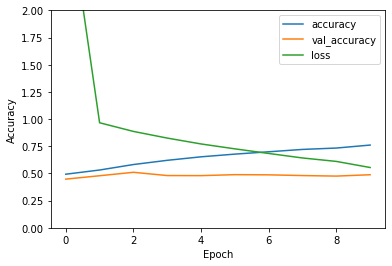

In [251]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 2])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)